In [73]:
import itertools
import functools
from collections import Counter, defaultdict
import pandas
from matplotlib import pyplot as pl
import numpy as np
import gc
import math
training_fname = 'data/PrediqtTrainData.Sample.5000000.csv'
airports_fname = 'data/PrediqtAirports.csv'
testing_fname = 'data/PrediqtTestDataSmall.csv'

In [74]:
training_data = pandas.read_csv(training_fname, dtype={
    'PRICE': float, 
})

In [75]:
for item, itemtype in {
    'OUTBOUND_DATE': 'datetime64',  # can't believe you can't do this when parsing
    'INBOUND_DATE': 'datetime64',
    'SEARCH_DATEHOUR': 'datetime64[ns]',}.iteritems():
    print item
    training_data[item] = training_data[item].astype(itemtype)
gc.collect()

OUTBOUND_DATE
SEARCH_DATEHOUR
INBOUND_DATE


0

#Prices

In [76]:
training_data = training_data.sort_index(by='PRICE')

In [77]:
price_counts = training_data.PRICE.value_counts(sort=False)

In [78]:
num_prices = len(training_data.PRICE)
num_buckets = 150.
buckets = [0.]
running_total = 0
for price, count in price_counts.sort_index().iteritems():
    running_total += count
    if running_total >= num_prices / num_buckets:
        buckets.append(price)
        running_total = 0
buckets.append(price * 1.01)
print buckets
del price_counts

[0.0, 42.090000000000003, 54.539999999999999, 65.200000000000003, 75.180000000000007, 84.540000000000006, 93.579999999999998, 101.37, 109.22, 117.23, 124.98, 132.09999999999999, 139.38999999999999, 145.88, 151.69999999999999, 157.97, 163.19999999999999, 169.18000000000001, 173.97999999999999, 179.97999999999999, 185.28, 190.13999999999999, 195.49000000000001, 199.97999999999999, 204.97999999999999, 209.97999999999999, 215.28999999999999, 219.97999999999999, 225.03999999999999, 229.97999999999999, 235.31, 239.97999999999999, 245.40000000000001, 250.03999999999999, 256.12, 260.98000000000002, 268.79000000000002, 273.80000000000001, 279.98000000000002, 287.73000000000002, 294.49000000000001, 300.98000000000002, 309.98000000000002, 319.22000000000003, 326.98000000000002, 335.56, 343.29000000000002, 353.22000000000003, 362.81, 373.98000000000002, 384.76999999999998, 396.98000000000002, 409.23000000000002, 421.81, 435.98000000000002, 449.98000000000002, 464.98000000000002, 479.98000000000002

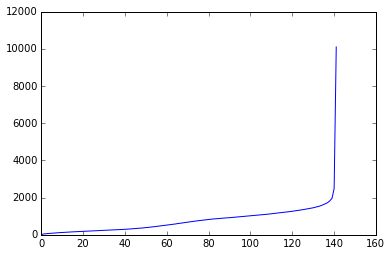

In [79]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot(buckets)
pl.show()

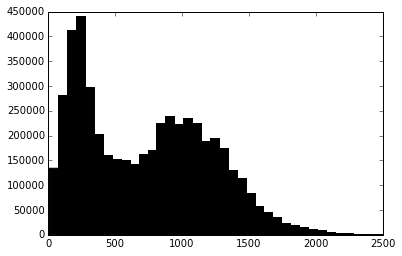

In [80]:
pl.hist(training_data.PRICE, num_buckets, color='black')
pl.xlim([0, 2500])
pl.show()

In [81]:
bucket_counts = [0 for __ in xrange(int(num_buckets) + 1)]
bucket_ranges = zip(xrange(int(num_buckets) + 1), buckets, buckets[1:])
print len(training_data.PRICE)
for i_, price in enumerate(training_data.PRICE):
    for i, low, high in bucket_ranges:
        if low <= price <= high:
            bucket_counts[i] += 1
            break
    if bucket_ranges[0][-1] < price:
        bucket_ranges = bucket_ranges[1:]
        print 'adjusting range', bucket_ranges[0]

5000000
adjusting range (1, 42.090000000000003, 54.539999999999999)
adjusting range (2, 54.539999999999999, 65.200000000000003)
adjusting range (3, 65.200000000000003, 75.180000000000007)
adjusting range (4, 75.180000000000007, 84.540000000000006)
adjusting range (5, 84.540000000000006, 93.579999999999998)
adjusting range (6, 93.579999999999998, 101.37)
adjusting range (7, 101.37, 109.22)
adjusting range (8, 109.22, 117.23)
adjusting range (9, 117.23, 124.98)
adjusting range (10, 124.98, 132.09999999999999)
adjusting range (11, 132.09999999999999, 139.38999999999999)
adjusting range (12, 139.38999999999999, 145.88)
adjusting range (13, 145.88, 151.69999999999999)
adjusting range (14, 151.69999999999999, 157.97)
adjusting range (15, 157.97, 163.19999999999999)
adjusting range (16, 163.19999999999999, 169.18000000000001)
adjusting range (17, 169.18000000000001, 173.97999999999999)
adjusting range (18, 173.97999999999999, 179.97999999999999)
adjusting range (19, 179.97999999999999, 185.28

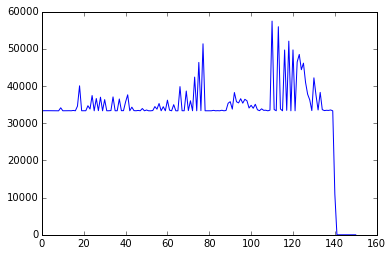

In [82]:
%matplotlib inline
pl.plot(bucket_counts)
pl.show()

I think bucket_counts looks better than bin_counts.

In [83]:
print buckets

[0.0, 42.090000000000003, 54.539999999999999, 65.200000000000003, 75.180000000000007, 84.540000000000006, 93.579999999999998, 101.37, 109.22, 117.23, 124.98, 132.09999999999999, 139.38999999999999, 145.88, 151.69999999999999, 157.97, 163.19999999999999, 169.18000000000001, 173.97999999999999, 179.97999999999999, 185.28, 190.13999999999999, 195.49000000000001, 199.97999999999999, 204.97999999999999, 209.97999999999999, 215.28999999999999, 219.97999999999999, 225.03999999999999, 229.97999999999999, 235.31, 239.97999999999999, 245.40000000000001, 250.03999999999999, 256.12, 260.98000000000002, 268.79000000000002, 273.80000000000001, 279.98000000000002, 287.73000000000002, 294.49000000000001, 300.98000000000002, 309.98000000000002, 319.22000000000003, 326.98000000000002, 335.56, 343.29000000000002, 353.22000000000003, 362.81, 373.98000000000002, 384.76999999999998, 396.98000000000002, 409.23000000000002, 421.81, 435.98000000000002, 449.98000000000002, 464.98000000000002, 479.98000000000002

In [84]:
len(buckets)

142

In [85]:
def convert(num, buckets=buckets, bucket_ranges=None):
    """go from 0..1 to larger"""
    buckets = tuple(buckets)
    if bucket_ranges is None:
        bucket_ranges = itertools.izip(buckets, buckets[1:])
    step = 1 / float(len(buckets))
    cumsum = 0
    for low, high in bucket_ranges:
        if cumsum <= num < cumsum + step:
            t = (num - cumsum) / step
            return (1 - t) * low + t * high
        cumsum += step
    t = (num - (cumsum - step)) / step
    return (1 - t) * low + t * high

def reverse_convert(num, buckets, _range=range(12), cache={}):
    """go from larger to 0..1"""
    buckets = tuple(buckets)
    key = (num, buckets)
    try:
        return cache[key]
    except KeyError:
        pass
    
    # Binary search, because I couldn't spend time to figure it out properly... oh well
    bucket_ranges = zip(buckets, buckets[1:])
    high, low = 0., 1.
    for __ in _range:
        mid = (high + low) / 2.
        result = convert(mid, buckets=buckets, bucket_ranges=bucket_ranges)
        if abs(result - num) < 0.001:
            break
        if result > num:
            low = mid
        else:
            high = mid
            
    cache[key] = mid
    return mid

In [86]:
print convert(.992)
print convert(.9925)
print convert(.993)
print convert(.9935)

9063.4635872
9603.531463
10143.5993388
10683.6672146


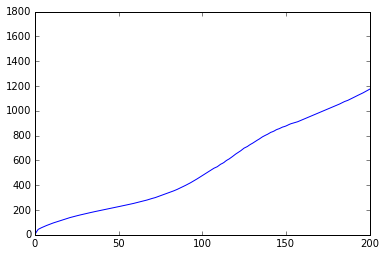

In [87]:
%matplotlib inline
pl.plot([convert(i / 250.) for i in xrange(250)])
pl.xlim([0, 200])
pl.ylim([0, 1800])
pl.show()

In [88]:
reverse_convert_price = functools.partial(reverse_convert, buckets=buckets)
training_data['PRICE'] = training_data['PRICE'].apply(reverse_convert_price)
gc.collect()

0

In [89]:
training_data.describe()

,PRICE
count,5000000.000000
mean,0.506741
std,0.285974
min,0.001709
25%,0.256592
50%,0.514893
75%,0.763428
max,0.992920


#Timedeltas

In [90]:
training_data['SEARCH_TO_OUTBOUND'] = training_data.OUTBOUND_DATE - training_data.SEARCH_DATEHOUR

In [91]:
training_data['SEARCH_TO_INBOUND'] = training_data.INBOUND_DATE - training_data.SEARCH_DATEHOUR

In [92]:
del training_data['SEARCH_DATEHOUR']

In [93]:
training_data['OUTBOUND_TO_INBOUND'] = training_data.INBOUND_DATE - training_data.OUTBOUND_DATE

In [94]:
one_day = 1000000000 * 60 * 60 * 24
oti_days = training_data.OUTBOUND_TO_INBOUND.map(lambda x: x.item() / one_day)

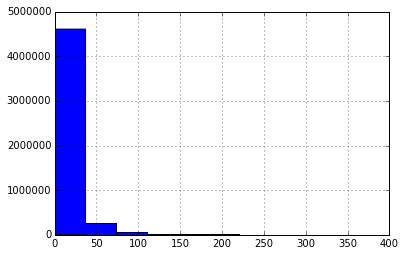

In [95]:
oti_days.hist()

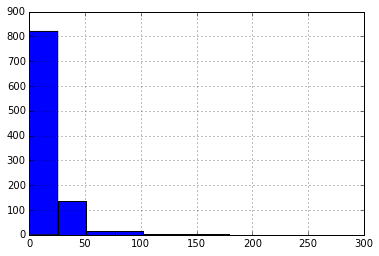

In [96]:
oti_days.sample(1000).hist()

In [97]:
oti_out, oti_bins = pandas.qcut(oti_days, 10, retbins=True)
oti_bins[-1] = int(oti_bins[-1] * 1.01)

In [98]:
oti_bins

array([   0.,    3.,    4.,    7.,    9.,   12.,   15.,   19.,   24.,
         33.,  371.])

In [99]:
oti_out.sample(500).value_counts(sort=False)

[0, 3]       101
(3, 4]        25
(4, 7]        82
(7, 9]        30
(9, 12]       46
(12, 15]      45
(15, 19]      45
(19, 24]      47
(24, 33]      42
(33, 368]     37
dtype: int64

In [100]:
convert(0.5, oti_bins)

13.499999999999998

In [101]:
reverse_convert_oti = functools.partial(reverse_convert, buckets=oti_bins)
scaled_oti_days = oti_days.apply(reverse_convert_oti)

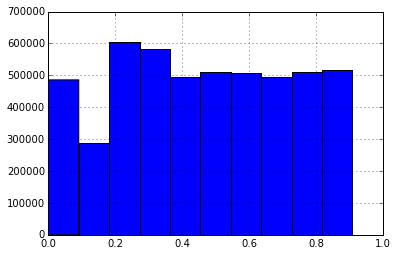

In [102]:
scaled_oti_days.hist()

In [103]:
scaled_oti_days.describe()

count    5000000.000000
mean           0.445235
std            0.256802
min            0.000244
25%            0.242432
50%            0.454346
75%            0.672607
max            0.908447
Name: OUTBOUND_TO_INBOUND, dtype: float64

In [104]:
training_data['OUTBOUND_TO_INBOUND'] = scaled_oti_days
gc.collect()

16

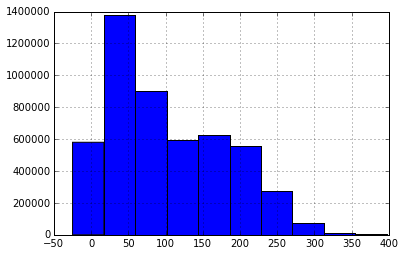

In [105]:
one_day = 1000000000 * 60 * 60 * 24
sto_days = training_data.SEARCH_TO_OUTBOUND.map(lambda x: x.item() / one_day)
sto_days.hist()

In [106]:
sto_out, sto_bins = pandas.qcut(sto_days, 10, retbins=True)
sto_bins[-1] = int(sto_bins[-1] * 1.01)
sto_bins

array([ -25.,   15.,   29.,   43.,   61.,   81.,  112.,  146.,  180.,
        215.,  400.])

In [107]:
sto_out.sample(500).value_counts(sort=False)

[-25, 15]     46
(15, 29]      51
(29, 43]      51
(43, 61]      51
(61, 81]      65
(81, 112]     48
(112, 146]    41
(146, 180]    56
(180, 215]    47
(215, 397]    44
dtype: int64

In [108]:
reverse_convert_sto = functools.partial(reverse_convert, buckets=sto_bins)
training_data['SEARCH_TO_OUTBOUND'] = sto_days.apply(reverse_convert_sto)
gc.collect()

0

In [109]:
sti_days = training_data.SEARCH_TO_INBOUND.map(lambda x: x.item() / one_day)
sti_out, sti_bins = pandas.qcut(sti_days, 10, retbins=True)
sti_bins[-1] = int(sti_bins[-1] * 1.01)
print sti_bins
reverse_convert_sti = functools.partial(reverse_convert, buckets=sti_bins)
training_data['SEARCH_TO_INBOUND'] = sti_days.apply(reverse_convert_sti)
gc.collect()

[  -1.   27.   43.   60.   79.   99.  131.  166.  202.  235.  408.]


14

In [110]:
training_data.describe()

,PRICE,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND
count,5000000.000000,5000000.000000,5000000.000000,5000000.000000
mean,0.506741,0.453634,0.452273,0.445235
std,0.285974,0.253537,0.256176,0.256802
min,0.001709,0.000244,0.000244,0.000244
25%,0.256592,0.220947,0.224365,0.242432
50%,0.514893,0.454346,0.454346,0.454346
75%,0.763428,0.681885,0.681885,0.672607
max,0.992920,0.907471,0.906982,0.908447


#Airports data

In [111]:
airports_data = pandas.read_csv(airports_fname)

In [112]:
training_merged = pandas.merge(training_data, airports_data, left_on='ORIGIN', right_on='AIRPORT')
del training_data

In [113]:
for key in ('AIRPORT', 'CITY', 'CONTINENT'):
    del training_merged[key]
training_merged.head()

,ORIGIN,DESTINATION,OUTBOUND_DATE,INBOUND_DATE,PRICE,MARKETS,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,COUNTRY,LATITUDE,LONGITUDE,TRAFFIC
0,SZZ,RYG,2016-01-15,2016-01-25,0.001709,ES,0.079346,0.068115,0.393799,PL,53.583333,14.9,76133
1,SZZ,STN,2016-01-20,2016-01-27,0.002686,PL,0.097412,0.077881,0.272705,PL,53.583333,14.9,76133
2,SZZ,RYG,2016-01-29,2016-02-01,0.002686,PL,0.129639,0.081299,0.091064,PL,53.583333,14.9,76133
3,SZZ,STN,2016-03-05,2016-03-06,0.003662,PL,0.343506,0.261963,0.030273,PL,53.583333,14.9,76133
4,SZZ,SVG,2016-01-16,2016-01-19,0.004150,PL,0.074951,0.038818,0.091064,PL,53.583333,14.9,76133


In [114]:
for key in ('COUNTRY', 'LATITUDE', 'LONGITUDE', 'TRAFFIC'):
    training_merged['ORIGIN_' + key] = training_merged[key]
    del training_merged[key]

In [115]:
training_merged = pandas.merge(training_merged, airports_data, left_on='DESTINATION', right_on='AIRPORT')
for key in ('AIRPORT', 'CITY', 'CONTINENT'):
    del training_merged[key]
for key in ('COUNTRY', 'LATITUDE', 'LONGITUDE', 'TRAFFIC'):
    training_merged['DESTINATION_' + key] = training_merged[key]
    del training_merged[key]
training_merged.head()

,ORIGIN,DESTINATION,OUTBOUND_DATE,INBOUND_DATE,PRICE,MARKETS,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_TRAFFIC,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_TRAFFIC
0,SZZ,RYG,2016-01-15,2016-01-25,0.001709,ES,0.079346,0.068115,0.393799,PL,53.583333,14.900000,76133,NO,59.3789,10.7856,278640
1,SZZ,RYG,2016-01-29,2016-02-01,0.002686,PL,0.129639,0.081299,0.091064,PL,53.583333,14.900000,76133,NO,59.3789,10.7856,278640
2,SZZ,RYG,2016-01-08,2016-01-11,0.010010,PL,0.063721,0.022705,0.091064,PL,53.583333,14.900000,76133,NO,59.3789,10.7856,278640
3,WMI,RYG,2016-02-04,2016-02-16,0.002686,PL,0.156006,0.147705,0.454346,PL,52.460298,20.657294,932470,NO,59.3789,10.7856,278640
4,WMI,RYG,2016-02-26,2016-02-28,0.002686,PL,0.298096,0.219482,0.060791,PL,52.460298,20.657294,932470,NO,59.3789,10.7856,278640


In [116]:
#training_merged = training_merged.sort('PRICE')
del airports_data
gc.collect()

91

In [117]:
#for key in (
#    'ORIGIN', 'DESTINATION', 'ORIGIN_CITY', 'ORIGIN_COUNTRY', 
#    'ORIGIN_CONTINENT', 'DESTINATION_CITY', 'DESTINATION_COUNTRY', 
#    'DESTINATION_CONTINENT',
#):
#    training_merged[key] = training_merged[key].astype('category')
#training_merged.head()

#Categorical data (one-hot encodings)

##Markets

In [118]:
market_counts = Counter(
    market
    for __, marketlist in 
    training_merged.MARKETS.iteritems()
    for market in
    marketlist.split(';')
)
print market_counts.most_common(10)

[('**', 3442333), ('UK', 487969), ('US', 213188), ('IT', 152141), ('FR', 150781), ('DE', 146748), ('ES', 142819), ('SK', 105670), ('TR', 101978), ('AT', 99244)]


In [119]:
len(market_counts)

248

In [120]:
most_common_markets = [market for market, __ in market_counts.most_common(99)]
print most_common_markets

['**', 'UK', 'US', 'IT', 'FR', 'DE', 'ES', 'SK', 'TR', 'AT', 'PL', 'PT', 'RU', 'IE', 'HU', 'CZ', 'GR', 'BR', 'BG', 'RO', 'NL', 'CH', 'TW', 'HK', 'MT', 'IL', 'BE', 'SA', 'CA', 'KW', 'MO', 'SI', 'QA', 'KZ', 'BH', 'IS', 'OM', 'BY', 'GE', 'ME', 'MD', 'LB', 'AZ', 'AD', 'SM', 'VA', 'HR', 'LI', 'BA', 'GL', 'FO', 'MK', 'KO', 'BV', 'MN', 'LU', 'WF', 'TF', 'BN', 'WS', 'TL', 'GU', 'PW', 'PG', 'PN', 'MP', 'FJ', 'FM', 'VU', 'NU', 'CK', 'CC', 'CX', 'KH', 'SB', 'TV', 'TO', 'TK', 'AS', 'LK', 'MV', 'BT', 'BQ', 'GS', 'HM', 'MH', 'UM', 'MS', 'NF', 'CW', 'SX', 'KI', 'SJ', 'LA', 'AN', 'AQ', 'IO', 'MC', 'RS']


In [121]:
market_onehots = np.zeros((len(training_merged.MARKETS), 100), dtype='bool')
for i, (marketlist, onehot) in enumerate(itertools.izip(training_merged.MARKETS, market_onehots)):
    ms = marketlist.split(';')
    for m in ms:
        try:
            onehot[most_common_markets.index(m)] = True
        except ValueError:
            onehot[-1] = True
    if not i % 1000000:
        print i

0
1000000
2000000
3000000
4000000


In [122]:
training_merged.MARKETS.tail(2)

4999998                                                   **
4999999    VN;IN;KW;ID;HM;TH;TR;UM;MY;MH;IL;GI;NF;MO;TW;W...
Name: MARKETS, dtype: object

In [123]:
sum(market_onehots[-1])

83

In [124]:
sum(market_onehots[-2])

1

In [125]:
import gc
gc.collect()

9

In [126]:
training_merged['MARKETS'] = list(market_onehots)
training_merged.MARKETS.loc[0]

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [127]:
del market_onehots
gc.collect()

10

In [128]:
training_merged.MARKETS.head()

0    [False, False, False, False, False, False, Tru...
1    [False, False, False, False, False, False, Fal...
2    [False, False, False, False, False, False, Fal...
3    [False, False, False, False, False, False, Fal...
4    [False, False, False, False, False, False, Fal...
Name: MARKETS, dtype: object

In [129]:
training_merged.dtypes

ORIGIN                           object
DESTINATION                      object
OUTBOUND_DATE            datetime64[ns]
INBOUND_DATE             datetime64[ns]
PRICE                           float64
MARKETS                          object
SEARCH_TO_OUTBOUND              float64
SEARCH_TO_INBOUND               float64
OUTBOUND_TO_INBOUND             float64
ORIGIN_COUNTRY                   object
ORIGIN_LATITUDE                 float64
ORIGIN_LONGITUDE                float64
ORIGIN_TRAFFIC                    int64
DESTINATION_COUNTRY              object
DESTINATION_LATITUDE            float64
DESTINATION_LONGITUDE           float64
DESTINATION_TRAFFIC               int64
dtype: object

##Other

In [130]:
def make_onehot(df, field, size):
    series = df[field]
    counts = Counter(series)
    print len(counts)
    most_common = [item for item, __ in counts.most_common(size)]
    print most_common
    most_common_set = frozenset(most_common)
    excluded = sum(place not in most_common_set for place in series) / float(len(series))
    print excluded
    zeros_size = len(most_common) + (1 if excluded > 0 else 0)
    onehots = np.zeros((len(series), zeros_size), dtype='bool')
    most_common_index = most_common.index
    for i, (item, onehot) in enumerate(itertools.izip(series, onehots)):
        try:
            onehot[most_common_index(item)] = True
        except ValueError:
            onehot[zeros_size - 1] = True
        if not i % 1000000:
            print i
    df[field] = list(onehots)
    return df

In [131]:
pairs = {
    'ORIGIN': 149,
    'ORIGIN_COUNTRY': 24,
    'DESTINATION': 224,
    'DESTINATION_COUNTRY': 49,
}
for field, size in pairs.iteritems():
    print field
    gc_collect_1 = gc.collect()
    training_merged = make_onehot(training_merged, field, size)
    print gc.collect() + gc_collect_1

ORIGIN
2150
['MAN', 'LHR', 'FRA', 'LGW', 'CDG', 'AMS', 'MAD', 'BHX', 'DUS', 'MUC', 'STN', 'MXP', 'BRU', 'GLA', 'SVO', 'FCO', 'HAM', 'BCN', 'GRU', 'IST', 'GIG', 'ZRH', 'MEX', 'STR', 'CGN', 'EMA', 'YYZ', 'DUB', 'CUN', 'TXL', 'DME', 'CPH', 'NCL', 'ATH', 'VCE', 'VIE', 'LIS', 'LAX', 'WAW', 'BUD', 'GVA', 'BLQ', 'LED', 'HAJ', 'LIN', 'BRS', 'EDI', 'JFK', 'HEL', 'PRG', 'ORY', 'ARN', 'LBA', 'SFO', 'EZE', 'LPL', 'OSL', 'SXF', 'BIO', 'MSP', 'OPO', 'LYS', 'TFS', 'IAH', 'DFW', 'BOG', 'BWI', 'BLL', 'MRS', 'RIX', 'BSL', 'PDX', 'TLL', 'BSB', 'LTN', 'SJO', 'SEA', 'BKK', 'TLV', 'VCP', 'OAK', 'POA', 'PMI', 'VNO', 'SOF', 'SIN', 'SCL', 'BGY', 'AYT', 'LEJ', 'REC', 'AAL', 'TLS', 'YUL', 'NCE', 'LJU', 'CNF', 'MCO', 'FOR', 'YVR', 'LAS', 'KBP', 'FLR', 'BEG', 'LCA', 'BRE', 'OTP', 'ZAG', 'BFS', 'CWL', 'CPT', 'SJC', 'KRK', 'DEN', 'BUR', 'TRN', 'BOS', 'JED', 'ORD', 'VRN', 'JNB', 'SKG', 'AGP', 'GOT', 'SSA', 'LIM', 'GDL', 'CCS', 'HAV', 'NAP', 'ONT', 'CAI', 'SYD', 'PHX', 'LCY', 'NUE', 'AUS', 'CWB', 'ISP', 'FLL', 'MEL', 

In [132]:
gc.collect()

0

Doesn't seem like we need to rescale traffics based on distributions

In [133]:
training_merged.head()

,ORIGIN,DESTINATION,OUTBOUND_DATE,INBOUND_DATE,PRICE,MARKETS,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_TRAFFIC,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_TRAFFIC
0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2016-01-15,2016-01-25,0.001709,"[False, False, False, False, False, False, Tru...",0.079346,0.068115,0.393799,"[False, False, False, False, False, False, Fal...",53.583333,14.900000,76133,"[False, False, False, False, False, False, Fal...",59.3789,10.7856,278640
1,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2016-01-29,2016-02-01,0.002686,"[False, False, False, False, False, False, Fal...",0.129639,0.081299,0.091064,"[False, False, False, False, False, False, Fal...",53.583333,14.900000,76133,"[False, False, False, False, False, False, Fal...",59.3789,10.7856,278640
2,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2016-01-08,2016-01-11,0.010010,"[False, False, False, False, False, False, Fal...",0.063721,0.022705,0.091064,"[False, False, False, False, False, False, Fal...",53.583333,14.900000,76133,"[False, False, False, False, False, False, Fal...",59.3789,10.7856,278640
3,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2016-02-04,2016-02-16,0.002686,"[False, False, False, False, False, False, Fal...",0.156006,0.147705,0.454346,"[False, False, False, False, False, False, Fal...",52.460298,20.657294,932470,"[False, False, False, False, False, False, Fal...",59.3789,10.7856,278640
4,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2016-02-26,2016-02-28,0.002686,"[False, False, False, False, False, False, Fal...",0.298096,0.219482,0.060791,"[False, False, False, False, False, False, Fal...",52.460298,20.657294,932470,"[False, False, False, False, False, False, Fal...",59.3789,10.7856,278640


#Traffic

In [134]:
o_traffic = sorted(training_merged.ORIGIN_TRAFFIC)
o_traffic[0], o_traffic[-1]

(3, 17262579)

In [135]:
d_traffic = sorted(training_merged.DESTINATION_TRAFFIC)
d_traffic[0], d_traffic[-1]

(2, 17262579)

In [136]:
traffic_max = int(max(o_traffic[-1], d_traffic[-1]) * 1.01)
traffic_max

17435204

In [137]:
training_merged['ORIGIN_TRAFFIC'] = training_merged.ORIGIN_TRAFFIC / traffic_max
training_merged['DESTINATION_TRAFFIC'] = training_merged.DESTINATION_TRAFFIC / traffic_max

In [138]:
training_merged.ORIGIN_TRAFFIC.describe()

count    5.000000e+06
mean     3.195292e-01
std      2.996625e-01
min      1.720657e-07
25%      8.425792e-02
50%      2.262477e-01
75%      5.086684e-01
max      9.900991e-01
Name: ORIGIN_TRAFFIC, dtype: float64

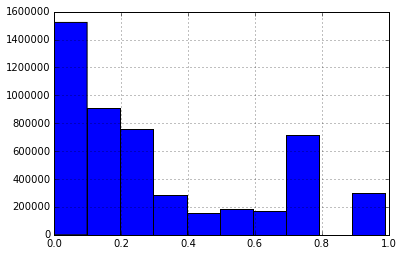

In [139]:
training_merged.ORIGIN_TRAFFIC.hist()

#Coordinates and distance

In [140]:
for key in ('ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'DESTINATION_LATITUDE', 'DESTINATION_LONGITUDE'):
    print key
    training_merged[key] = training_merged[key].apply(math.radians)
training_merged.describe()

ORIGIN_LATITUDE
ORIGIN_LONGITUDE
DESTINATION_LATITUDE
DESTINATION_LONGITUDE


,PRICE,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_TRAFFIC,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_TRAFFIC
count,5000000.000000,5000000.000000,5000000.000000,5000000.000000,5000000.000000,5000000.000000,5.000000e+06,5000000.000000,5000000.000000,5.000000e+06
mean,0.506741,0.453634,0.452273,0.445235,0.748370,-0.092526,3.195292e-01,0.463728,-0.247605,1.649103e-01
std,0.285974,0.253537,0.256176,0.256802,0.330153,0.699533,2.996625e-01,0.396724,1.094432,1.949162e-01
min,0.001709,0.000244,0.000244,0.000244,-0.957196,-3.074688,1.720657e-07,-0.957196,-3.139443,1.147104e-07
25%,0.256592,0.220947,0.224365,0.242432,0.720869,-0.039735,8.425792e-02,0.321650,-1.294540,3.501674e-02
50%,0.514893,0.454346,0.454346,0.454346,0.873343,0.004072,2.262477e-01,0.592248,-0.038363,8.762324e-02
75%,0.763428,0.681885,0.681885,0.672607,0.915479,0.161928,5.086684e-01,0.719948,0.335685,2.262477e-01
max,0.992920,0.907471,0.906982,0.908447,1.498074,3.116285,9.900991e-01,1.498074,3.130151,9.900991e-01


In [141]:
sin, cos, acos = math.sin, math.cos, math.acos
def distance(row):
    lat1 = row['ORIGIN_LATITUDE']
    lon1 = row['ORIGIN_LONGITUDE']
    lat2 = row['DESTINATION_LATITUDE']
    lon2 = row['DESTINATION_LONGITUDE']
    
    delta_lambda = lon2 - lon1
    
    return acos(
        sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(delta_lambda)
    ) * 6371

In [142]:
gc.collect()

0

In [143]:
training_merged['DISTANCE'] = training_merged.apply(distance, axis=1)
training_merged.DISTANCE.describe()

count    5000000.000000
mean        5878.728469
std         3565.865104
min            0.000000
25%         2333.570940
50%         6840.748628
75%         8845.476013
max        19942.040333
Name: DISTANCE, dtype: float64

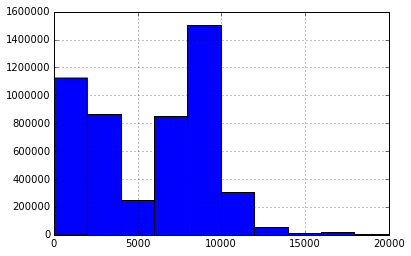

In [144]:
training_merged.DISTANCE.hist()

In [145]:
gc.collect()

0

In [148]:
for key in 'ORIGIN_LATITUDE ORIGIN_LONGITUDE DESTINATION_LATITUDE DESTINATION_LONGITUDE DISTANCE'.split():
    print key
    sorted_values = sorted(training_merged[key])
    minimum, maximum = sorted_values[0] * 1.01, sorted_values[-1] * 1.01
    print minimum, maximum
    training_merged[key] = (training_merged[key] - minimum) / (maximum - minimum)
    print gc.collect()

ORIGIN_LATITUDE
-0.966767766679 1.51305442978
48
ORIGIN_LONGITUDE
-3.10543525513 3.14744823323
0
DESTINATION_LATITUDE
-0.966767766679 1.51305442978
0
DESTINATION_LONGITUDE
-3.17083736087 3.16145255339
0


In [153]:
training_merged.describe()

,PRICE,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_TRAFFIC,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_TRAFFIC,DISTANCE
count,5000000.000000,5000000.000000,5000000.000000,5000000.000000,5000000.000000,5000000.000000,5.000000e+06,5000000.000000,5000000.000000,5.000000e+06,5000000.000000
mean,0.506741,0.453634,0.452273,0.445235,0.691637,0.481843,3.195292e-01,0.576854,0.461639,1.649103e-01,0.291872
std,0.285974,0.253537,0.256176,0.256802,0.133136,0.111874,2.996625e-01,0.159981,0.172834,1.949162e-01,0.177041
min,0.001709,0.000244,0.000244,0.000244,0.003860,0.004917,1.720657e-07,0.003860,0.004958,1.147104e-07,0.000000
25%,0.256592,0.220947,0.224365,0.242432,0.680548,0.490286,8.425792e-02,0.519560,0.296306,3.501674e-02,0.115859
50%,0.514893,0.454346,0.454346,0.454346,0.742033,0.497292,2.262477e-01,0.628681,0.494683,8.762324e-02,0.339635
75%,0.763428,0.681885,0.681885,0.672607,0.759025,0.522537,5.086684e-01,0.680176,0.553753,2.262477e-01,0.439168
max,0.992920,0.907471,0.906982,0.908447,0.993959,0.995016,9.900991e-01,0.993959,0.995057,9.900991e-01,0.990099


In [154]:
training_merged.head()

,ORIGIN,DESTINATION,OUTBOUND_DATE,INBOUND_DATE,PRICE,MARKETS,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_TRAFFIC,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_TRAFFIC,DISTANCE
0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2016-01-15,2016-01-25,0.001709,"[False, False, False, False, False, False, Tru...",0.079346,0.068115,0.393799,"[False, False, False, False, False, False, Fal...",0.766980,0.53823,0.004367,"[False, False, False, False, False, False, Fal...",0.80777,0.530469,0.015981,0.034350
1,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2016-01-29,2016-02-01,0.002686,"[False, False, False, False, False, False, Fal...",0.129639,0.081299,0.091064,"[False, False, False, False, False, False, Fal...",0.766980,0.53823,0.004367,"[False, False, False, False, False, False, Fal...",0.80777,0.530469,0.015981,0.034350
2,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2016-01-08,2016-01-11,0.010010,"[False, False, False, False, False, False, Fal...",0.063721,0.022705,0.091064,"[False, False, False, False, False, False, Fal...",0.766980,0.53823,0.004367,"[False, False, False, False, False, False, Fal...",0.80777,0.530469,0.015981,0.034350
3,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2016-02-04,2016-02-16,0.002686,"[False, False, False, False, False, False, Fal...",0.156006,0.147705,0.454346,"[False, False, False, False, False, False, Fal...",0.759076,0.55430,0.053482,"[False, False, False, False, False, False, Fal...",0.80777,0.530469,0.015981,0.048799
4,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2016-02-26,2016-02-28,0.002686,"[False, False, False, False, False, False, Fal...",0.298096,0.219482,0.060791,"[False, False, False, False, False, False, Fal...",0.759076,0.55430,0.053482,"[False, False, False, False, False, False, Fal...",0.80777,0.530469,0.015981,0.048799


In [152]:
#for key in ('DISTANCE',):
#    print key
#    sorted_values = sorted(training_merged[key])
#    minimum, maximum = sorted_values[0] * 1.01, sorted_values[-1] * 1.01
#    print minimum, maximum
#    training_merged[key] = (training_merged[key] - minimum) / (maximum - minimum)
#    print gc.collect()

DISTANCE
0.0 20141.4607366
8


In [155]:
training_merged.loc[0].OUTBOUND_DATE

Timestamp('2016-01-15 00:00:00')

In [156]:
dir(training_merged.loc[0].OUTBOUND_DATE)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__qualname__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rsub__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '_date_repr',
 '_get_field',
 '_get_start_end_field',
 '_has_time_component',
 '_repr_base',
 '_time_repr',
 'asm8',
 'astimezone',
 'combine',
 'ctime',
 'date',
 'day',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'daysinmonth',
 'dst',
 'freq',
 'freqstr',
 'fromordinal',
 'fromtimestamp',
 'hour',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_year_end',
 'is_year_start',
 'isocalendar',
 'isoformat',
 'isoweekday',
 'max',
 'microsecond',
 'min',
 'minute',
 'month',
 'nanosecond',
 'normalize',
 'now',
 'offset',

In [158]:
training_merged.loc[0].OUTBOUND_DATE.weekday()

4

In [160]:
training_merged.loc[0].OUTBOUND_DATE.month

1

In [162]:
training_merged.loc[0].OUTBOUND_DATE.day

15

In [166]:
def onehot_encode_date(date):
    array = np.zeros((7 + 12 + 31,), dtype='bool')
    array[date.weekday() - 1] = True
    array[date.month + 7 - 1] = True
    array[date.day + 7 + 12 - 1] = True
    return array

In [164]:
training_merged.sample(5).OUTBOUND_DATE.apply(onehot_encode_date)

559435     [False, False, False, False, False, False, Tru...
2670405    [False, False, False, False, True, False, Fals...
2866107    [False, False, False, True, False, False, Fals...
981403     [False, False, False, False, False, False, Tru...
4117305    [False, False, False, False, True, False, Fals...
Name: OUTBOUND_DATE, dtype: object

In [167]:
training_merged['OUTBOUND_DATE'] = training_merged.OUTBOUND_DATE.apply(onehot_encode_date)
gc.collect()
training_merged['INBOUND_DATE'] = training_merged.INBOUND_DATE.apply(onehot_encode_date)
gc.collect()

0

In [168]:
training_merged.head()

,ORIGIN,DESTINATION,OUTBOUND_DATE,INBOUND_DATE,PRICE,MARKETS,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_TRAFFIC,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_TRAFFIC,DISTANCE
0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, True, False, False, Fals...","[False, False, False, False, False, False, Fal...",0.001709,"[False, False, False, False, False, False, Tru...",0.079346,0.068115,0.393799,"[False, False, False, False, False, False, Fal...",0.766980,0.53823,0.004367,"[False, False, False, False, False, False, Fal...",0.80777,0.530469,0.015981,0.034350
1,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, True, False, False, Fals...","[False, False, False, False, False, False, Fal...",0.002686,"[False, False, False, False, False, False, Fal...",0.129639,0.081299,0.091064,"[False, False, False, False, False, False, Fal...",0.766980,0.53823,0.004367,"[False, False, False, False, False, False, Fal...",0.80777,0.530469,0.015981,0.034350
2,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, True, False, False, Fals...","[False, False, False, False, False, False, Fal...",0.010010,"[False, False, False, False, False, False, Fal...",0.063721,0.022705,0.091064,"[False, False, False, False, False, False, Fal...",0.766980,0.53823,0.004367,"[False, False, False, False, False, False, Fal...",0.80777,0.530469,0.015981,0.034350
3,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, True, False, False, False, Fals...","[True, False, False, False, False, False, Fals...",0.002686,"[False, False, False, False, False, False, Fal...",0.156006,0.147705,0.454346,"[False, False, False, False, False, False, Fal...",0.759076,0.55430,0.053482,"[False, False, False, False, False, False, Fal...",0.80777,0.530469,0.015981,0.048799
4,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, True, False, False, Fals...","[False, False, False, False, False, True, Fals...",0.002686,"[False, False, False, False, False, False, Fal...",0.298096,0.219482,0.060791,"[False, False, False, False, False, False, Fal...",0.759076,0.55430,0.053482,"[False, False, False, False, False, False, Fal...",0.80777,0.530469,0.015981,0.048799
